In [31]:
import os
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize Sentiment analyzer
analyzer = SentimentIntensityAnalyzer() 

def calculate_sentiment(text):
    """Calculates sentiment using VADER. Add preprocessing if needed"""
    score = analyzer.polarity_scores(text)['compound']  
    return score

def process_data(apple_path, samsung_path):
    results = []
    for filename in os.listdir(apple_path) + os.listdir(samsung_path): 
        if filename.startswith('a_'):
            brand = 'apple'
        elif filename.startswith('s_'):
            brand = 'samsung'
        else:
            continue  

        # Extract date from filename (dd-mm-yyyy format)
        date_str = filename.split('_')[2] + "-" + filename.split('_')[1] + "-" + filename.split('_')[3].split('.')[0] 

        # Reformat date for sorting  (mm-dd-yyyy)
        mmddyyyy_date_str = date_str[3:5] + "-" + date_str[:2] + "-" + date_str[6:]

        filepath = os.path.join(apple_path if brand == 'apple' else samsung_path, filename)
        df = pd.read_csv(filepath)

        # Calculate daily sentiment 
        daily_sentiment = df['tweet_text_element'].apply(calculate_sentiment).mean()

        # Find or create the matching date entry 
        existing_entry = next((item for item in results if item['day'] == mmddyyyy_date_str), None) 
        if existing_entry:
            existing_entry[f'{brand}_sentiment'] = daily_sentiment
        else:   
            results.append({
                'day': mmddyyyy_date_str,  
                f'{brand}_sentiment': daily_sentiment 
            })

    # Sort after processing all files 
    results.sort(key=lambda item: item['day'])  

    return pd.DataFrame(results)

# Example usage with the specific paths
apple_path = 'Apple'
samsung_path = 'Samsung'
df = process_data(apple_path, samsung_path)
df.to_csv('sentiment_analysis_results.csv', index=False, date_format='%m-%d-%Y')  # index=False to avoid an extra index column



In [32]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def calculate_influence(df):
    # Normalize sentiment scores
    scaler = MinMaxScaler()
    df[['apple_sentiment', 'samsung_sentiment']] = scaler.fit_transform(df[['apple_sentiment', 'samsung_sentiment']])

    # Correlation-based influence
    correlation = np.corrcoef(df['apple_sentiment'], df['samsung_sentiment'])[0, 1]
    abs_correlation = abs(correlation)

    influence_apple_on_samsung = abs_correlation * 100 
    influence_samsung_on_apple = abs_correlation * 100 

    return influence_apple_on_samsung, influence_samsung_on_apple

# Load the data
df = pd.read_csv('sentiment_analysis_results.csv')

# Calculate influences
influence_apple_on_samsung, influence_samsung_on_apple = calculate_influence(df)

print(f"Influence of Apple on Samsung: {influence_apple_on_samsung:.2f}%")
print(f"Influence of Samsung on Apple: {influence_samsung_on_apple:.2f}%")


Influence of Apple on Samsung: 18.60%
Influence of Samsung on Apple: 18.60%


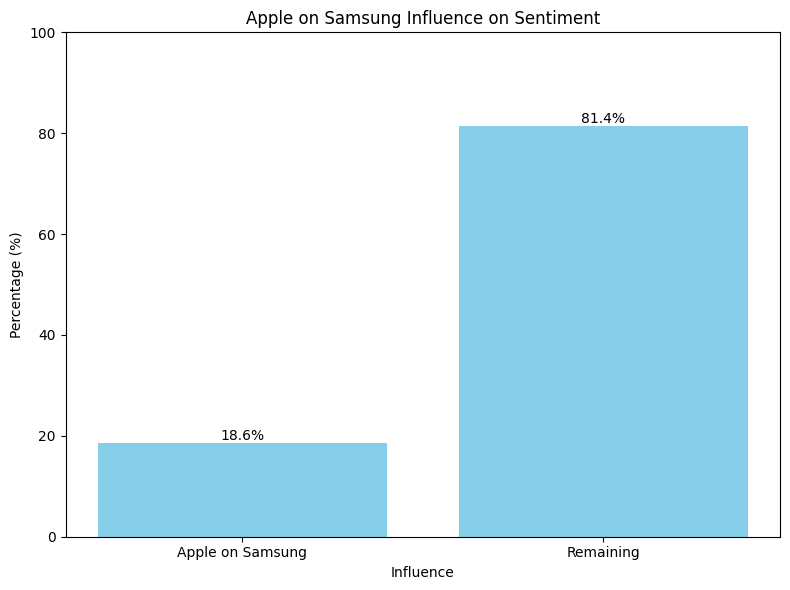

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data (replace with your actual influence values)
brand = "Apple on Samsung"  
influence_percentage = influence_apple_on_samsung

# Create data for the bar graph
data = {'Influence Score (%)': [influence_percentage, 100 - influence_percentage]}
df = pd.DataFrame(data, index=[brand, 'Remaining'])

# Constants for styling
SELECTED_COLOR = 'indianred'  

def on_click(event):
    # Clear previous selection (if any)
    for bar in bars:
        bar.set_color('skyblue')  # Or your original color

    # Highlight the clicked bar
    if event.inaxes == ax: 
        event.artist.set_color(SELECTED_COLOR)
        fig.canvas.draw()  # Redraw the canvas

# Create the bar graph
fig, ax = plt.subplots(figsize=(8, 6))  
bars = ax.bar(df.index, df['Influence Score (%)'], color='skyblue')
plt.xlabel('Influence')
plt.ylabel('Percentage (%)')
plt.title(f"{brand} Influence on Sentiment")
plt.ylim(0, 100) 

# Add percentage labels (optional)
for bar in bars:
    value = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2.0
    y = bar.get_y() + value  
    plt.text(x, y, f"{value:.1f}%", ha='center', va='bottom') 

fig.canvas.mpl_connect('button_press_event', on_click)
plt.tight_layout()
plt.show()


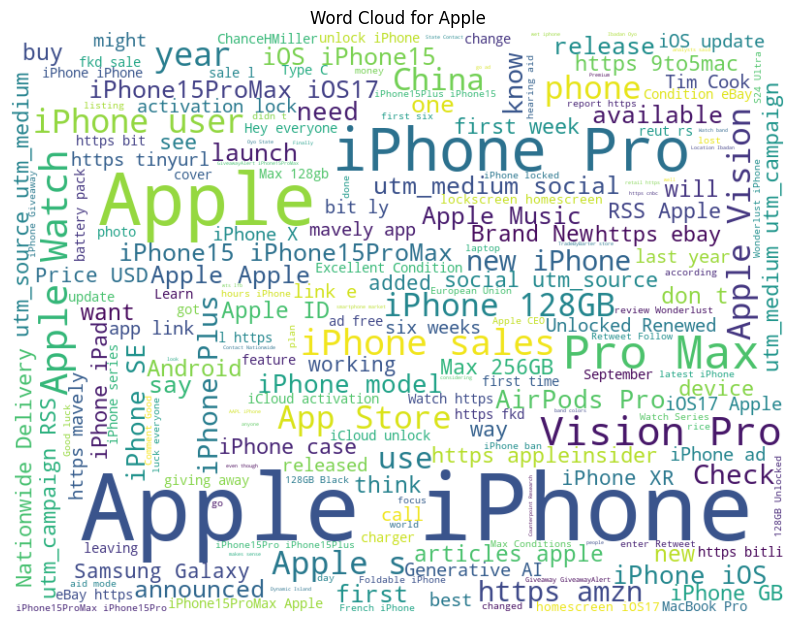

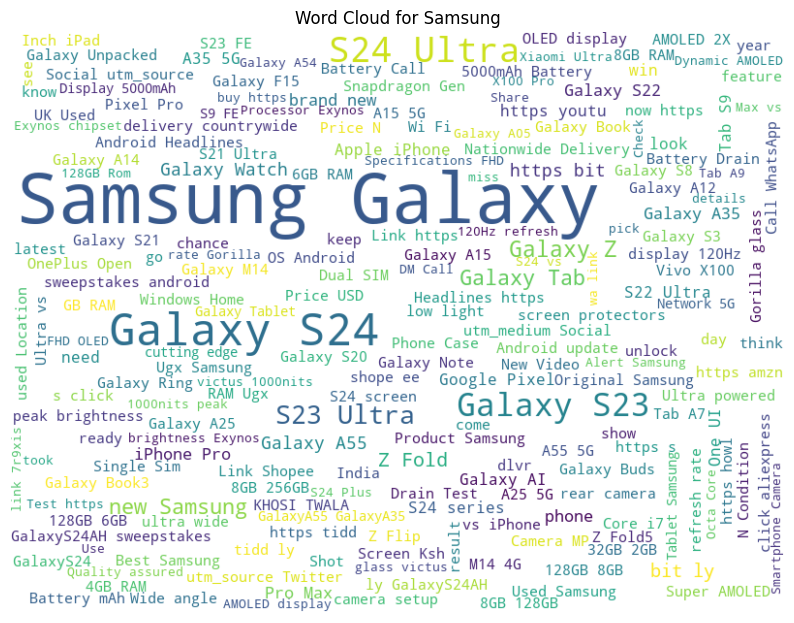

In [33]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import os

def generate_wordcloud(brand_data, brand_name):
    text = " ".join(tweet for tweet in brand_data['tweet_text_element'])
    wordcloud = WordCloud(background_color='white', width=800, height=600).generate(text)

    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {brand_name}")
    plt.show()

def process_data(apple_path, samsung_path):
    all_data = []
    for path, brand in [(apple_path, 'Apple'), (samsung_path, 'Samsung')]:
        for filename in os.listdir(path):
            if filename.startswith(brand.lower()[0] + '_'):  
                filepath = os.path.join(path, filename)
                df = pd.read_csv(filepath)
                df['brand'] = brand  
                all_data.append(df)

    combined_df = pd.concat(all_data)
    return combined_df

# Example usage
apple_path = 'Apple'  # Update with your folder paths
samsung_path = 'Samsung' 
df = process_data(apple_path, samsung_path)

# Generate word clouds for each brand
for brand in df['brand'].unique():
    brand_data = df[df['brand'] == brand]
    generate_wordcloud(brand_data, brand)


<Figure size 1200x600 with 0 Axes>

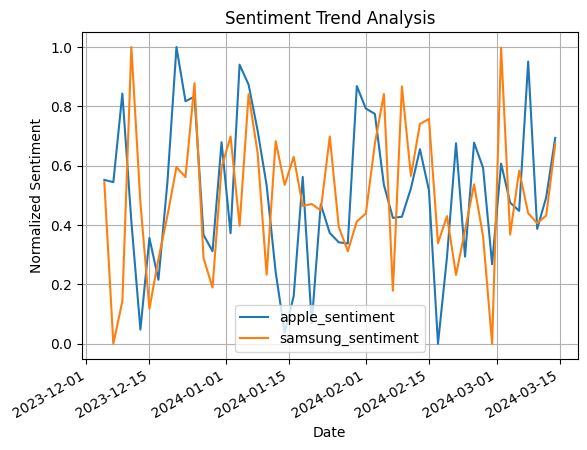

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming the data file is named 'sentiment_analysis_results.csv'
data_path = 'sentiment_analysis_results.csv'

try:
  # Read the data from the CSV file
  df = pd.read_csv(data_path)

  # Check if 'day', 'apple_sentiment', and 'samsung_sentiment' columns exist
  if all(col in df.columns for col in ['day', 'apple_sentiment', 'samsung_sentiment']):
    # Convert date strings to datetime format
    df['day'] = pd.to_datetime(df['day'], format='%d-%m-%Y')

    # Normalize sentiment scores (0-1 range)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    df[['apple_sentiment', 'samsung_sentiment']] = scaler.fit_transform(df[['apple_sentiment', 'samsung_sentiment']])

    # Plot sentiment trends (corrected)
    plt.figure(figsize=(12, 6))
    df.plot(x='day', y=['apple_sentiment', 'samsung_sentiment']) 
    plt.xlabel('Date')
    plt.ylabel('Normalized Sentiment')
    plt.title('Sentiment Trend Analysis')
    plt.grid(True)
    plt.legend()
    plt.show()
  else:
    print(f"Error: The data file '{data_path}' is missing required columns.")

except FileNotFoundError:
  print(f"Error: The data file '{data_path}' could not be found.")


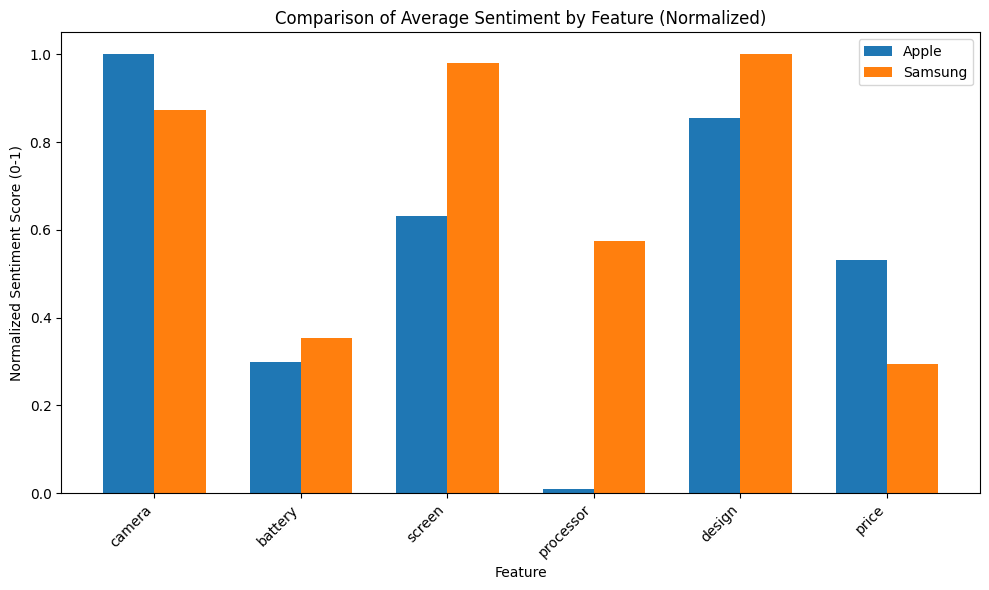

In [34]:
sentiment_scores = {}  # Initialize an empty dictionary to store sentiment scores

def calculate_feature_sentiment(tweet_text, feature_keywords):
    sentiment_score = 0  # Initialize
    if any(word in tweet_text for word in feature_keywords):
        sentiment_score = analyzer.polarity_scores(tweet_text)['compound']
    return sentiment_score

features = {
    "camera": ["camera", "photo", "picture", "lens", "image quality"], 
    "battery": ["battery", "charge", "life", "battery drain"],
    "screen": ["screen", "display", "resolution", "oled", "amoled"],
    "processor": ["processor", "speed", "chip", "snapdragon", "performance", "bionic","a14"], 
    "design": ["design", "look", "feel", "build quality"],
    "price": ["price", "expensive", "cheap", "value"]
}

for brand in df['brand'].unique():
    for feature, keywords in features.items():
        feature_df = df[df['brand'] == brand].copy()  # Create a copy here
        feature_df[f"{feature}_sentiment"] = feature_df['tweet_text_element'].apply(calculate_feature_sentiment, args=(keywords,))

        avg_sentiment = feature_df[f"{feature}_sentiment"].fillna(0).mean()
        # print(f"{brand} - {feature} Average Sentiment: {avg_sentiment:.3f}")
        
        # Store the calculated sentiment score in the dictionary
        if brand not in sentiment_scores:
            sentiment_scores[brand] = {}
        sentiment_scores[brand][feature] = avg_sentiment

# Print the sentiment scores dictionary
# print(sentiment_scores)

import matplotlib.pyplot as plt

# Sample sentiment data (replace with your actual results)
sentiment_data = sentiment_scores

# Normalize sentiment scores (assuming values range from 0 to 1)
def normalize_sentiment(sentiment_dict):
    for brand, features in sentiment_dict.items():
        max_value = max(features.values())
        for feature, sentiment in features.items():
            sentiment_dict[brand][feature] = sentiment / max_value
    return sentiment_dict

sentiment_data = normalize_sentiment(sentiment_data.copy())  # Normalize on a copy

# Extract feature labels and sentiment scores for each brand
brands = list(sentiment_data.keys())
feature_labels = list(sentiment_data[brands[0]].keys())
apple_sentiment = [sentiment_data["Apple"][feature] for feature in feature_labels]
samsung_sentiment = [sentiment_data["Samsung"][feature] for feature in feature_labels]

# Create a bar chart
plt.figure(figsize=(10, 6))
x = range(len(feature_labels))
bar_width = 0.35
plt.bar(x, apple_sentiment, bar_width, label='Apple')
plt.bar([p + bar_width for p in x], samsung_sentiment, bar_width, label='Samsung')
plt.xlabel('Feature')
plt.ylabel('Normalized Sentiment Score (0-1)')
title = 'Comparison of Average Sentiment by Feature (Normalized)'
plt.title(title)
plt.xticks([p + bar_width / 2 for p in x], feature_labels, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


Top Features for Apple: ['camera', 'battery', 'screen']
Top Features for Samsung: ['camera', 'battery', 'screen']


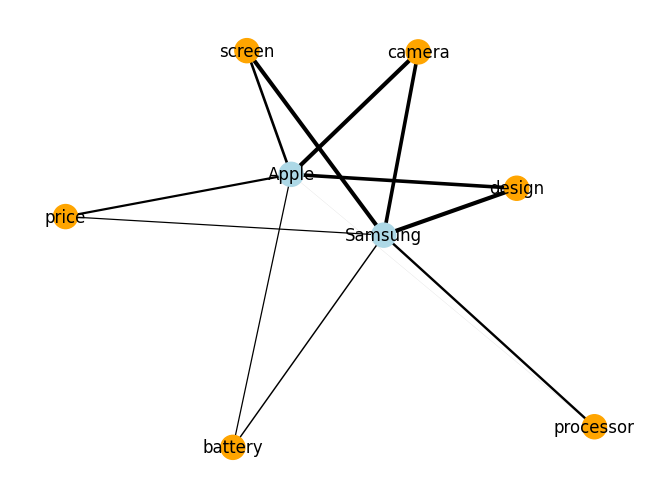

In [35]:
import networkx as nx

G = nx.Graph()

# Add brands and features as nodes
brands = sentiment_scores.keys()
features = list(sentiment_scores["Apple"].keys())  # Assuming features are the same across brands

for brand in brands:
    G.add_node(brand, type="brand")  

for feature in features:
    G.add_node(feature, type="feature") 

sentiment_threshold = 0.01  # Example threshold

for brand, feature_data in sentiment_scores.items():
    for feature, sentiment in feature_data.items():
        if sentiment >= sentiment_threshold: 
            G.add_edge(brand, feature, weight=sentiment)

# Node Importance
degree_centrality = nx.degree_centrality(G)  

for brand in brands:
    brand_features = [n for n in G.neighbors(brand)]  # Features connected to a brand
    top_features = sorted(brand_features, key=lambda x: degree_centrality[x], reverse=True)[:3]
    print(f"Top Features for {brand}: {top_features}")

import matplotlib.pyplot as plt

# Customize visualization 
node_colors = ['lightblue' if G.nodes[n]['type'] == 'brand' else 'orange' for n in G.nodes()]
edge_widths = [d['weight'] * 3 for (_, _, d) in G.edges(data=True)]  # Adjust for visual clarity
pos = nx.spring_layout(G)  # You can experiment with different layouts

nx.draw(G, pos, with_labels=True, node_color=node_colors, width=edge_widths)
plt.show()